# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from dstoolkit.automl.classifier import AutoMLCatBoost, AutoMLCatBoostCV
from dstoolkit.metrics import plots
from dstoolkit.model import analysis 

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,
    flip_y=0.15,
    weights=[0.8, 0.2],
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera uma base sintética binária com splits train/valid/test.
    Retorna: (X_train, y_train, X_valid, y_valid, X_test, y_test)
    """

    # ---------------------------
    # 1. Gerar base sintética
    # ---------------------------
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        class_sep=class_sep,
        flip_y=flip_y,
        weights=weights,
        random_state=random_state
    )

    # ---------------------------
    # 2. Train/Test
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # ---------------------------
    # 3. Train/Validation
    # ---------------------------
    valid_relative = valid_size / (1 - test_size)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=valid_relative,
        stratify=y_train,
        random_state=random_state
    )

    y_train = pd.DataFrame(y_train, columns=['target'])
    y_valid = pd.DataFrame(y_valid, columns=['target'])
    y_test = pd.DataFrame(y_test, columns=['target'])
    
    return pd.DataFrame(X_train), y_train, pd.DataFrame(X_valid), y_valid, pd.DataFrame(X_test), y_test

# Database

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=5000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)

# Modeling

In [5]:
cat = AutoMLCatBoost(scoring='log_loss', tune=True, n_trials=20)
cat.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [6]:
model = cat.model

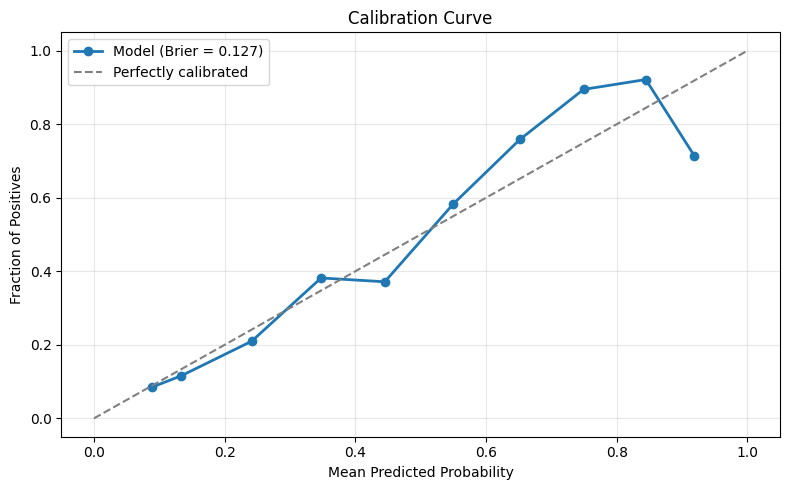

In [7]:
plots.plot_calibration_curve(y_true=y_test['target'], y_score=y_test['prob'], n_bins=10)

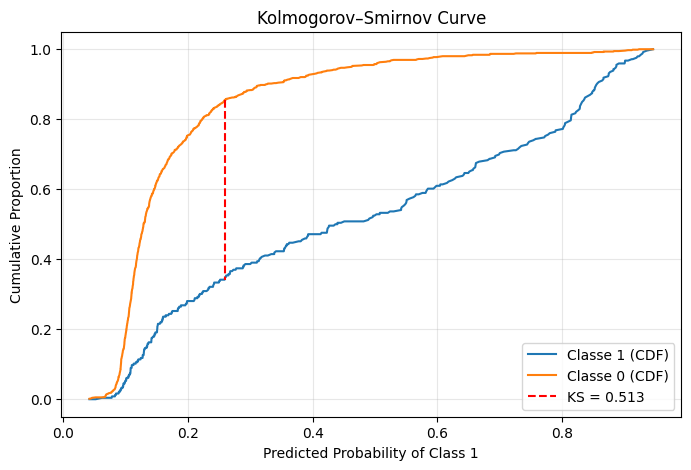

In [8]:
plots.plot_ks_curve(y_true=y_test['target'], y_score=y_test['prob'])

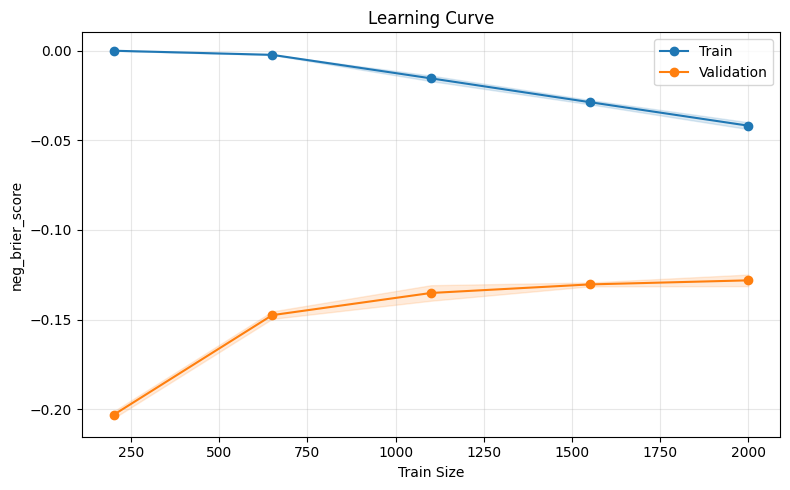

In [13]:
analysis.plot_learning_curve(model, X_train, y_train['target'], cv=StratifiedKFold(n_splits=3), scoring='neg_brier_score')

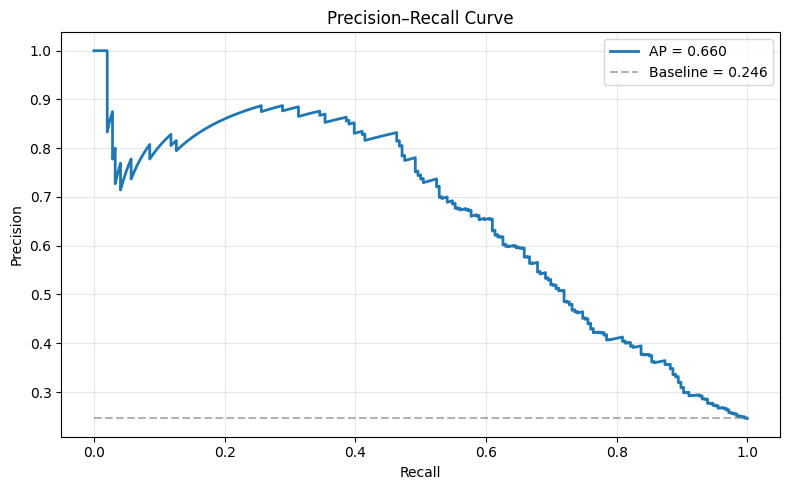

0.6599494810225208

In [14]:
plots.plot_precision_recall_curve(y_true=y_test['target'], y_score=y_test['prob'])

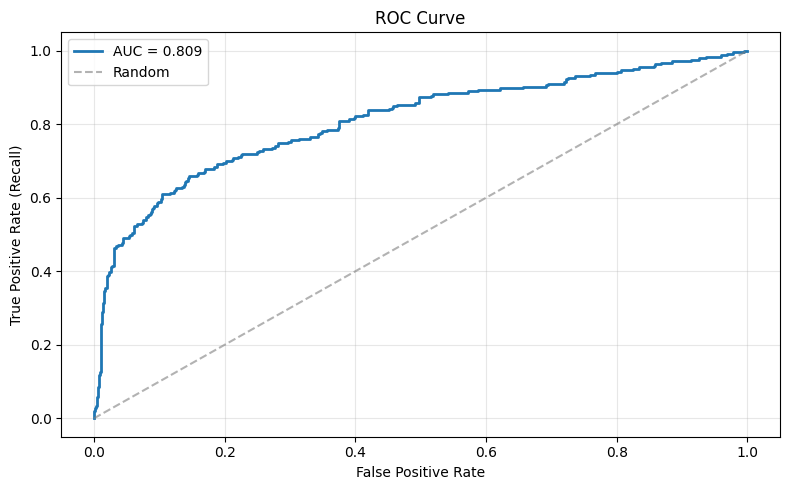

0.809288132669125

In [15]:
plots.plot_roc_curve(y_true=y_test['target'], y_score=y_test['prob'])